In [2]:
import os,glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import sys
import copy
import re
from pandas import ExcelFile
lib_path='/cndd/hop006/Github/'
excel_path=lib_path+'RewardReversalPorject/Data/UH2 Probabilistic Reversal Learning EEG.xlsx'
UH2_excel=pd.read_excel(excel_path,sheetname='Rat 30')
sys.path.append('/cndd/hop006/Github/RewardReversalPorject')
from ToyQ2 import *
from matplotlib.pyplot import *


data_path='/cndd/emukamel/UH2_DerAvakian/PRL_analysis/Data'
output_path='/cndd/hop006/Data/epoched_eeg/'
files=glob.glob(os.path.join(data_path,'*'))

FileNotFoundError: [Errno 2] No such file or directory: '/cndd/hop006/Github/RewardReversalPorject/Data/UH2 Probabilistic Reversal Learning EEG.xlsx'

In [ ]:
mats={}
i=0
for file in files:
    mats[file]=scipy.io.loadmat(file)
    i+=1
    print(i,end=',')
mats_df=pd.DataFrame(mats)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,

# Getting just one rat
## saved rat 29, 18, 23, 30 as pickle

In [161]:
def get_ephys(date,rat_num):
    for i in files:
        fn=i.split('/')[-1].split()
        for j in fn:
            if j.split('_')[0]==str(date):
                if j.split('_')[1]=='Rat'+str(rat_num):
                    return scipy.io.loadmat(i)
    print('doesnt exist')
    return
rat23=get_ephys(20180525,23)

# Data summary
## the ttl vector is converted to just 0 and 1

In [26]:
# def rat_summary(rat): # takes a single rat's data as a pd.Series object
#     tvecs,signals,low_tones,high_tones,tars,off_tars=[],[],[],[],[],[]
#     low_tone=rat['ttl'][0]
#     high_tone=rat['ttl'][1]
#     tar=rat['ttl'][2]
#     off_tar=rat['ttl'][3]
#     tvec=rat['tvec'][0]
#     adc='empty' if rat['adc'].size==0 else rat['adc'][0]
#     lfp='empty' if rat['lfp'].size==0 else rat['lfp']
#     eeg='empty' if rat['eeg'].size==0 else rat['eeg']
    
#     signal=lfp if lfp!='empty' else eeg
#     signal=np.array(signal)
    
#     duration=tvec.max()
#     zeros=np.where(tvec == tvec.min())[0]
#     n=(zeros[1]-zeros[0])
#     print('duration:',duration,'|num_recordings:',len(zeros)-1,'|n:',n)
#     for i in range(1,len(zeros)): # looping thru each reset of clock
#         tvecs.append(tvec[zeros[i-1]:zeros[i]])
#         low_tones.append(np.round(low_tone[zeros[i-1]:zeros[i]])) # rounding the decimals off
#         high_tones.append(np.round(high_tone[zeros[i-1]:zeros[i]]))
#         tars.append(np.round(tar[zeros[i-1]:zeros[i]]))
#         off_tars.append(np.round(off_tar[zeros[i-1]:zeros[i]]))
#         signals.append(signal[:,zeros[i-1]:zeros[i]])
#     return np.array(tvecs),np.array(signals),np.array(low_tones),np.array(high_tones),np.array(tars),np.array(off_tars)


In [723]:
def rat_summary(rat): # takes a single rat's data as a pd.Series object
    tvecs,signals,low_tones,high_tones,tars,off_tars=[],[],[],[],[],[]
    low_tone=np.round(rat['ttl'][0])
    high_tone=np.round(rat['ttl'][1])
    tar=np.round(rat['ttl'][2])
    off_tar=np.round(rat['ttl'][3])
    tvec=rat['tvec'][0]
    adc='empty' if rat['adc'].size==0 else rat['adc'][0]
    lfp='empty' if (rat['lfp'].size==0 or sum(sum(rat['lfp']))==0) else rat['lfp']
    eeg='empty' if (rat['eeg'].size==0 or sum(sum(rat['eeg']))==0) else rat['eeg']
    
    signal=lfp if lfp!='empty' else eeg
    signal=np.array(signal)
    
    return np.array(tvec),np.array(signal),np.array(low_tone),np.array(high_tone),np.array(tar),np.array(off_tar)


In [247]:
tvec,signal,low_tone,high_tone,tar,off_tar=rat_summary(rat23)

/home/AD/hop006/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


# Concat all the tvecs, remove artifact 
## eam live load eeg data 3times the inter quartile range as threshold 20180525 rat 23
# rat 9 aud erp

# Note on the data:
## low_tone is 3, high_tone is 4, on_target is 1, off_target is 2

In [741]:
def get_behavior(rat,eeg_length,plot=False): # each interval is around 0.002
    out=[]
    tvec,signal,low_tone,high_tone,tar,off_tar=rat_summary(rat)
    action_log=[]
    reward_log=[]
    epoched_eeg=[]
    if plot:
        ax = subplot(1,1,1)
        p1, = ax.plot(low_tone*3, label="low_tone")
        p2, = ax.plot(high_tone*4, label="high_tone")
        p3, = ax.plot(tar, label="targets")
        p4, = ax.plot(off_tar*2,label='off_targets')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1])

    zero_low_tone=np.where(low_tone == 0)[0]
    zero_high_tone=np.where(high_tone == 0)[0]
    zero_tar=np.where(tar == 0)[0]
    zero_off_tar=np.where(off_tar == 0)[0]
    low_tone_onset=zero_low_tone[(np.roll(zero_low_tone,1)-zero_low_tone)!=-1]
    high_tone_onset=zero_high_tone[(np.roll(zero_high_tone,1)-zero_high_tone)!=-1]
    tar_onset=zero_tar[(np.roll(zero_tar,1)-zero_tar)!=-1]
    off_tar_onset=zero_off_tar[(np.roll(zero_off_tar,1)-zero_off_tar)!=-1]
        
    zero_temp=np.zeros(tvec.shape)
    zero_temp[tar_onset]=1
    zero_temp[off_tar_onset]=2
    
    for j in np.nonzero(zero_temp)[0]:
        epoched_eeg.append(copy.deepcopy(signal[:,j-100:j+eeg_length]))
    
    zero_temp[low_tone_onset]=3
    zero_temp[high_tone_onset]=4
    
    log=zero_temp[np.nonzero(zero_temp)]
    action_log+=(log[log<3].tolist())
    reward_log+=(log[log>2].tolist())


#         if bool(list(reward_loss_onset)):
#             print(log)
    reward_log=np.array(reward_log)
    action_log=np.array(action_log)
    reward_log[reward_log==3]=1
    reward_log[reward_log==4]=0
    return action_log,reward_log,epoched_eeg

def eeg_by_label(rat,label_by_action,label_by_reward=None,label_by_chan=19,eeg_length=300): # the label_by_action is either 1 or 2
    action_log,reward_log,epoched_eeg=get_behavior(rat,eeg_length,plot=False)
    if label_by_action!=None:
        idx1=(action_log==label_by_action)
    else:
        idx1=np.ones(action_log.shape)
    if label_by_reward!=None:
        idx2=(reward_log==label_by_reward)
    else:
        idx2=np.ones(reward_log.shape)
    idx=(idx1*idx2).astype(dtype=int)
    out=[]
    for i in np.nonzero(idx)[0]:
        out.append(epoched_eeg[i][label_by_chan])
    return np.array(out)


# Rat23 is high_tone for reward

In [704]:
action_log,reward_log,epoched_eeg=get_behavior(rat23,300,plot=False);
tar_eeg=eeg_by_label(rat23,1)
off_tar_eeg=eeg_by_label(rat23,2)
hi_eeg=eeg_by_label(rat23,None,1)
low_eeg=eeg_by_label(rat23,None,0)

/home/AD/hop006/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


# EEG processing
## Removing artifact

In [705]:
from scipy.stats import kurtosis
def mask_by_std(eeg_in,zero_fill=False): # need to specify eeg channel here
    eeg=copy.deepcopy(eeg_in)
    std=np.std(eeg)
    m=np.mean(eeg)
#     artifact=(np.abs((eeg-m)/std))>3
    artifact=np.abs(eeg)>1500
    arti_onset=np.where(artifact==1)[0]
    for i in arti_onset:
        eeg[i-100:i+100]=np.nan
    return eeg

In [781]:
from scipy.signal import butter, sosfiltfilt, sosfreqz
from scipy.fftpack import fft, fftfreq, fftshift
# Credit for these functions goes to 'WarrenWeckesser'
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y
    
fs = 500.0     # 200 Hz sampling rate
low_cut  = 0.1; # EDIT THIS VARIABLE
high_cut = 30.0; # EDIT THIS VARIABLE
lowcut = 0.1   # 0.1 Hz is the lowest frequency we will pass
highcut = 30.0 # 30  Hz is the highest frequency we will pass.
order = 2;

def plot_average(eeg,fil=False,lowcut=None,highcut=None):
    fs=500.0
    order=2
    dt=1/fs
    temp=copy.deepcopy(eeg[:])
    out=[]
    for i,x in enumerate(temp):
        out.append(mask_by_std(x))
        if fil:
            if lowcut==None or highcut==None:
                lowcut=0.1
                highcut=30.0
            out[i]=butter_bandpass_filter(x, lowcut, highcut, fs, order)
    out=np.array(out)
    erp=np.nanmean(out,axis=0)
    plt.plot(erp)
    return erp

def spec_plot(eeg,fs=500):
    T=np.linspace(0,fs,num=len(eeg))
    FFTY=np.fft.fft(eeg)
    psd = np.abs(FFTY)**2
    plt.figure(1)
    plt.plot(T,psd)
    plt.yscale('log')
#     plt.xlim(50,150)
    plt.figure(2)
    plt.plot(eeg)
    
def get_excel_info(rat_num):
    excel_path=lib_path+'RewardReversalPorject/Data/UH2 Probabilistic Reversal Learning EEG.xlsx'
    UH2_excel=pd.read_excel(excel_path,sheetname='Rat '+str(rat_num))
    chan_info=UH2_excel.iloc[5:21,:3]
    trial_info=UH2_excel.iloc[22:,:]
    val_chan=[chan_info.iloc[i,0] for i in range(chan_info.shape[0]) if chan_info.iloc[i,1]!='blank']
    chan_name=[chan_info.iloc[i,1] for i in range(chan_info.shape[0]) if chan_info.iloc[i,1]!='blank']
    dates=[]
    rat_nums=[]
    for i in (trial_info.iloc[1:,1]):
        if not type(i)!=str:
            temp=i.split('_')
            date=temp[0]
            string1=temp[1]
            rat_num=int(re.search(r'\d+', string1).group())
            dates.append(date)
            rat_nums.append(rat_num)
    return val_chan,chan_name,dates,rat_nums

# Final Pipeline
## 1. Get rat info from get_excel_info(rat_num)
## 2. get the dataframe with get_ephys(date,rat_num)
## 3. get a summary using rat_summary(rat_df)
## 4. get the logs using get_behavior(rat_df,eeg_length,plot=False) where eeg_length is the number of sample each worth 0.002s and the plot is useless now
## 5. get eeg by label using eeg_by_label(rat_df, action, reward, chan_num, eeg_length) the action is 1 or 2; reward is 1 or 0; chan_num is the channel number)
## 6. Plot erp using plot_average(signal,fil) fil means if filter or not
## 7. spectrum plot using specplot(signal)

# Note
#### Stimtrackor fucks up my code, idk wtf is going on with these warning
#### rat 26 seems to be pretty good, lfp doesn't have any big artifact

In [769]:
val_chan,chan_name,dates,rat_nums=get_excel_info(26)
rat_df=get_ephys(dates[0],rat_nums[0])
tvec,signal,low_tone,high_tone,tar,off_tar=rat_summary(rat_df)
action_log,reward_log,epoched_eeg=get_behavior(rat_df,eeg_length=300,plot=False)

In [770]:
tar_eeg=eeg_by_label(rat_df,1)
off_tar_eeg=eeg_by_label(rat_df,2)
hi_eeg=eeg_by_label(rat_df,None,1)
low_eeg=eeg_by_label(rat_df,None,0)

# Comparing different scenarios
# In L Au1 LFP

In [771]:
tar_r=eeg_by_label(rat_df,1,1)
off_r=eeg_by_label(rat_df,2,1)
tar_n=eeg_by_label(rat_df,1,0)
off_n=eeg_by_label(rat_df,2,0)

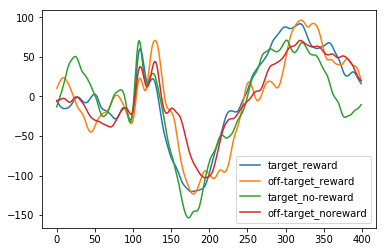

In [773]:
erp1=plot_average(tar_r,fil=True)
erp2=plot_average(off_r,fil=True)
erp3=plot_average(tar_n,fil=True)
erp4=plot_average(off_n,fil=True)
plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))

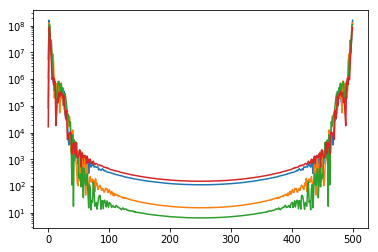

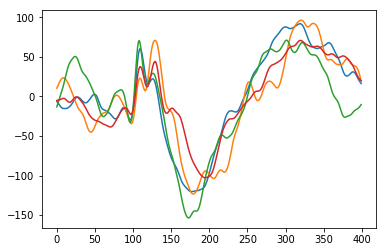

In [784]:
spec_plot(erp1)
spec_plot(erp2)
spec_plot(erp3)
spec_plot(erp4)

# LFP In ACC

In [778]:
tar_r1=eeg_by_label(rat_df,1,1,18)
off_r1=eeg_by_label(rat_df,2,1,18)
tar_n1=eeg_by_label(rat_df,1,0,18)
off_n1=eeg_by_label(rat_df,2,0,18)

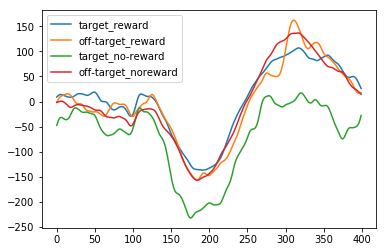

In [779]:
erp11=plot_average(tar_r1,fil=True)
erp22=plot_average(off_r1,fil=True)
erp33=plot_average(tar_n1,fil=True)
erp44=plot_average(off_n1,fil=True)
plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))

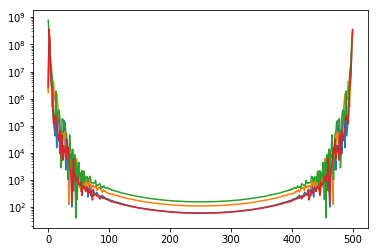

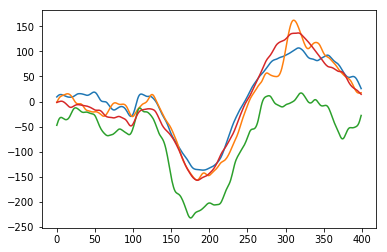

In [785]:
spec_plot(erp11)
spec_plot(erp22)
spec_plot(erp33)
spec_plot(erp44)